### 손실 함수를 커스텀 해보자

In [68]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [69]:
def my_huber_loss(y_true, y_pred):
    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

In [70]:
x = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
y = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x, y, epochs=500,verbose=0)

print(model.predict([10.0]))

model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=my_huber_loss)
model.fit(x, y, epochs=500,verbose=0)

print(model.predict([10.0]))

1/1 [==============================] - 0s 36ms/step
[[18.979588]]
1/1 [==============================] - 0s 43ms/step
[[18.612871]]


위 처럼 개인이 custom한 loss fucntion을 사용 할 수 있다. 

하지만 위와 같이 구현 하면 threshold 같은 parameter를 하드 코딩해야 한다.

아래처럼 wrapping을 해서 parameter로 threshold 전달하고 함수를 반환하는 함수를 만들어 주자. 

In [71]:
def my_huber_loss_with_threshold(threshold):
    def my_huber_loss(y_true, y_pred):
        error = y_true - y_pred
        flag = tf.abs(error) <= threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
        return tf.where(flag, small_error_loss, big_error_loss)
    return my_huber_loss

In [72]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer ='sgd', loss=my_huber_loss_with_threshold(threshold=1.2))
model.fit(x,y,epochs = 500,verbose = 0)
print(model.predict([10.0]))

1/1 [==============================] - 0s 38ms/step
[[18.618074]]


래퍼 펑션 대신 클래스로 커스텀 손실 함수를 구현해보자.

In [73]:
from tensorflow.keras.losses import Loss
class MyHuberLoss(Loss):
    def __init__(self, threshold = 1):
        super().__init__()
        self.threshold = threshold
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        flag = tf.abs(error) <= self.threshold
        sel = tf.square(error)/2
        bel = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(flag, sel, bel)


In [74]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1.02))
model.fit(x, y, epochs=500,verbose=0)
print(model.predict([10.0]))

1/1 [==============================] - 0s 36ms/step
[[18.583733]]


샤이미즈(샴) 네트워크의 손실 함수를 커스텀 해보자!

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
print(tf.__version__)

2.11.0


In [3]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d +inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    for i in digit_indices:
        print(i)
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show

Train_images는 28, 28, 3 의 이미지가 60000개 있다.
rgb 값은 0 ~ 255 정수 값이며 float32 으로 변환후 255 정규화를 해준다.

train_labels는 0 ~ 9 값을 가지며 60000개를 포함한다.




In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images/ 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

[    1     2     4 ... 59974 59985 59998]
[   16    21    38 ... 59989 59991 59996]
[    5     7    27 ... 59977 59981 59993]
[    3    20    25 ... 59971 59980 59997]
[   19    22    24 ... 59984 59986 59990]
[    8     9    12 ... 59983 59995 59999]
[   18    32    33 ... 59973 59987 59988]
[    6    14    41 ... 59951 59979 59992]
[   23    35    57 ... 59962 59967 59994]
[    0    11    15 ... 59932 59970 59978]
[  19   27   35   59   71   85   88   96  113  120  121  125  141  142
  143  155  164  170  177  180  201  206  223  229  235  260  263  264
  272  275  280  284  304  305  332  341  355  359  370  374  381  395
  400  403  410  440  452  454  458  463  464  472  488  489  499  501
  531  544  547  566  577  589  605  610  616  625  636  646  651  652
  656  672  674  677  681  691  703  714  719  720  731  736  737  751
  755  764  770  858  859  881  889  890  894  906  908  910  916  926
  930  937  948  951  954  955  959  965  985 1000 1005 1038 1049 1052
 1060 1069 1

In [5]:
print(len(train_images))
print(len(train_images[0]))
print(len(train_images[0][0]))
print(train_images[0][0])


60000
28
28
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


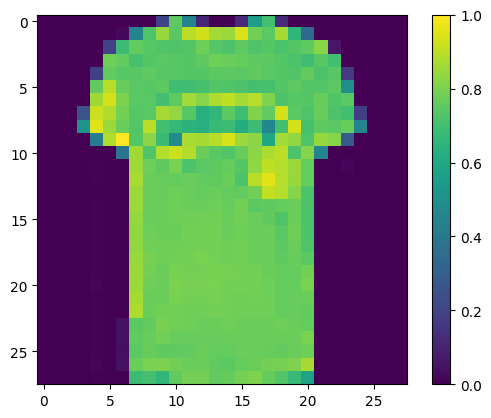

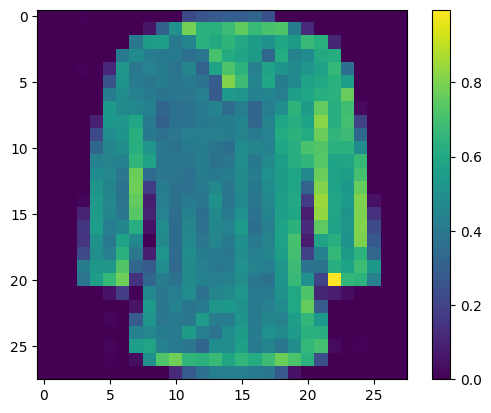

In [6]:
show_image(ts_pairs[1][0])
show_image(ts_pairs[1][1])

print()

In [10]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

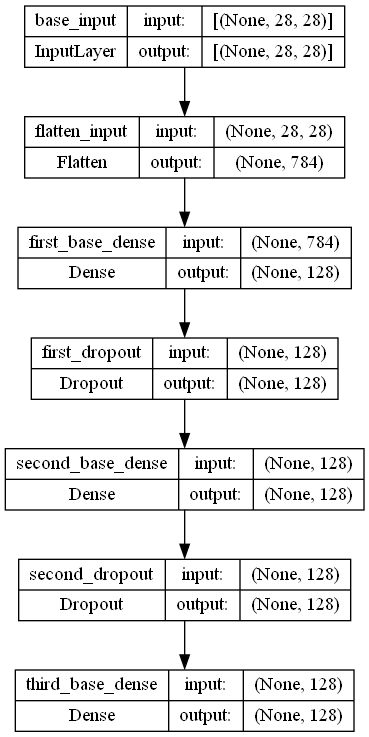

In [11]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

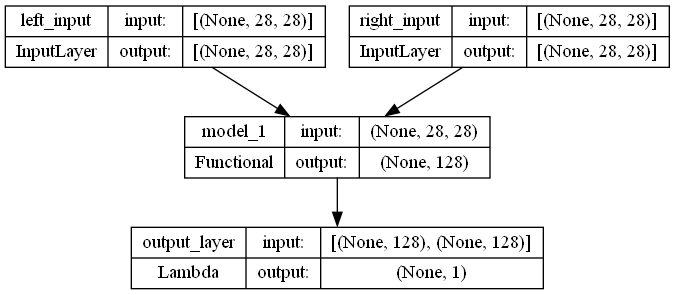

In [14]:
input_a = Input(shape= (28, 28), name= 'left_input')
vect_output_a = base_network(input_a)
input_b = Input(shape=(28, 28), name='right_input')
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name = 'output_layer', output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True, to_file="outer-model.png")

In [15]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [16]:
rms = RMSprop()
model.compile(loss = contrastive_loss_with_margin(margin =1), optimizer=rms)
history = model.fit([tr_pairs[:, 0],
                    tr_pairs[:, 1]],
                    tr_y,
                    epochs = 20,
                    batch_size = 128,
                    validation_data = ([ts_pairs[:, 0],
                                        ts_pairs[:, 1]], ts_y))

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1129 - val_loss: 0.0866
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0820 - val_loss: 0.0767
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0737 - val_loss: 0.0738
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0688 - val_loss: 0.0695
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0654 - val_loss: 0.0680
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0632 - val_loss: 0.0683
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0611 - val_loss: 0.0654
Epoch 8/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0601 - val_loss: 0.0664
Epoch 9/20
938/938 [==============================] - 4s 5ms/step - loss: 0.0585 - val_loss: 0.0706
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0575 - val_loss: 0.0649

In [17]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_pred)


In [18]:
loss = model.evaluate(x=[ts_pairs[:, 0], ts_pairs[:, 1]], y = ts_y)
y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_acc = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_acc = compute_accuracy(tr_y, y_pred_test)

print(loss, train_acc, test_acc)

625/625 [==============================] - 1s 1ms/step
0.06680221855640411 0.0 0.0


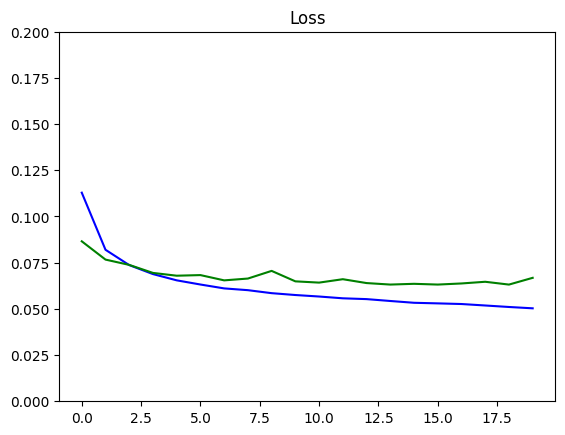

In [20]:
def plot_metrics(metric_name, title, ylim = 5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label = metric_name)
    plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)
plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [21]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


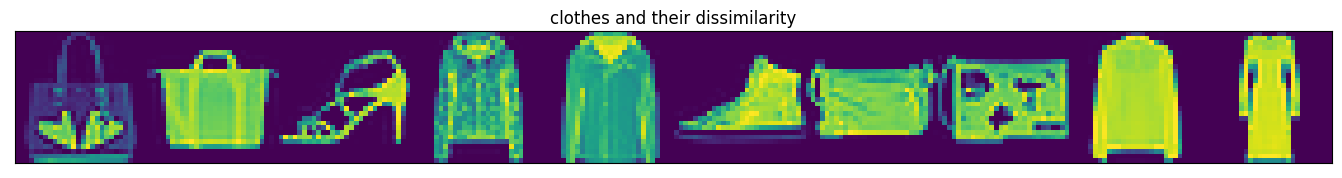

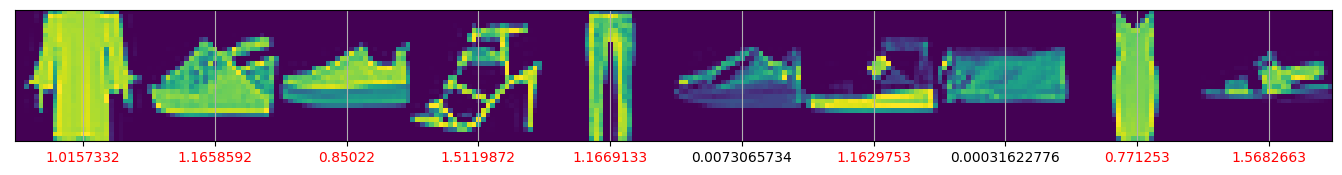

In [26]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)